In [41]:
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import json
import warnings
warnings.filterwarnings("ignore")
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [42]:
data = pd.read_json('xaimed_production.data_2_group.json')[['data']]

# with open(f'xaimed_production.data_2_grousp.json', 'r') as file:
#     data = json.load(file)
# data = pd.DataFrame(data)[['data']]

def get_ecg(row):
    try:
        return row['data']['ecg']['ecgArray']
    except:
        return None
ecg = pd.DataFrame(data.apply(get_ecg, axis = 1))
ecg.dropna(inplace = True)
ecg.rename({0 : 'ecg'}, axis = 1, inplace = True)
ecg = ecg.reset_index(False).drop(['index'], axis = 1)
ecg

,ecg
0,"[32767, 32767, 32767, 32767, 32767, 32767, 327..."
1,"[31675, 31498, 31278, 31641, 31688, 31013, 312..."
2,"[19599, 19582, 20035, 19607, 19251, 19648, 196..."
3,"[17195, 17801, 17948, 17230, 17609, 17976, 171..."
4,"[6220, 5821, 6170, 6561, 6059, 6079, 6562, 627..."
...,...
825,"[254, 261, 264, 264, 265, 264, 266, 267, 268, ..."
826,"[87, 95, 90, 87, 90, 88, 87, 89, 96, 88, 90, 9..."
827,"[46, 49, 49, 46, 46, 48, 48, 49, 50, 49, 50, 4..."
828,"[130, 138, 145, 141, 146, 150, 144, 135, 144, ..."


In [43]:
import pyhrv, biosppy
import neurokit2 as nk

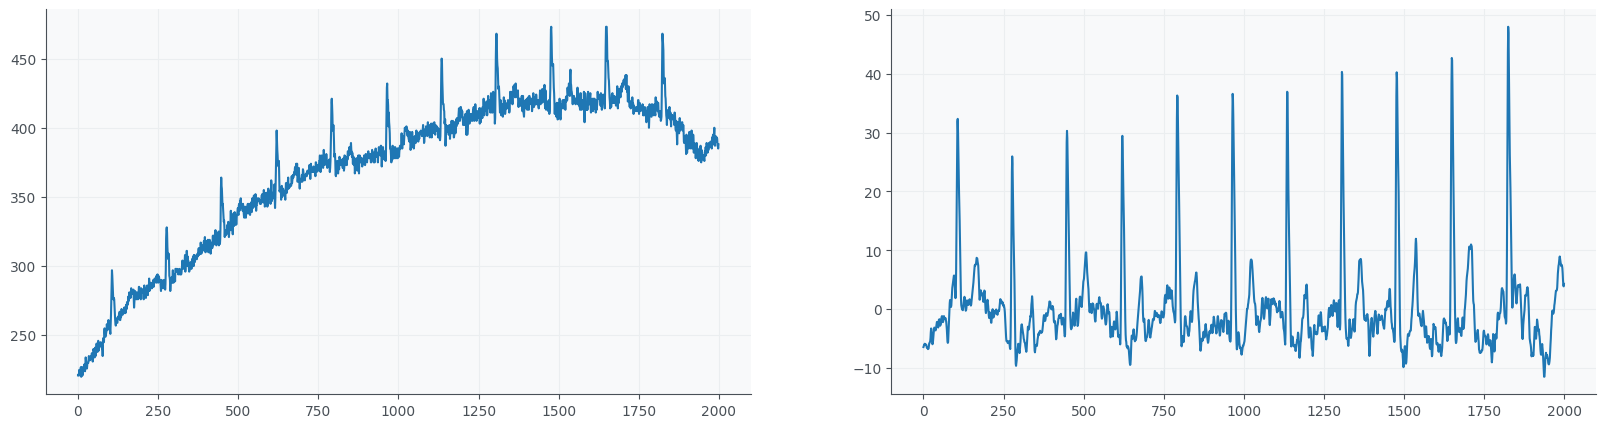

In [44]:
test_ecg = ecg.iloc[100]['ecg']
plt.figure(figsize = (20, 5))
plt.subplot(1,2,1)
plt.plot(test_ecg)
plt.subplot(1,2,2)
plt.plot(nk.ecg_clean(test_ecg, sampling_rate = 200, method = 'neurokit'))

In [65]:
nk.hrv_time(biosppy.signals.ecg.ecg(test_ecg, sampling_rate = 200, show = False)[2]).to_dict()

{'HRV_MeanNN': {0: 171.9},
 'HRV_SDNN': {0: 1.7919573407620815},
 'HRV_SDANN1': {0: nan},
 'HRV_SDNNI1': {0: nan},
 'HRV_SDANN2': {0: nan},
 'HRV_SDNNI2': {0: nan},
 'HRV_SDANN5': {0: nan},
 'HRV_SDNNI5': {0: nan},
 'HRV_RMSSD': {0: 2.0816659994661326},
 'HRV_SDSD': {0: 2.1278575558006176},
 'HRV_CVNN': {0: 0.01042441734009355},
 'HRV_CVSD': {0: 0.012109749851460922},
 'HRV_MedianNN': {0: 171.5},
 'HRV_MadNN': {0: 1.4826},
 'HRV_MCVNN': {0: 0.008644897959183674},
 'HRV_IQRNN': {0: 1.75},
 'HRV_SDRMSSD': {0: 0.8608284620211166},
 'HRV_Prc20NN': {0: 170.8},
 'HRV_Prc80NN': {0: 173.0},
 'HRV_pNN50': {0: 0.0},
 'HRV_pNN20': {0: 0.0},
 'HRV_MinNN': {0: 170.0},
 'HRV_MaxNN': {0: 176.0},
 'HRV_HTI': {0: 2.0},
 'HRV_TINN': {0: 0.0}}

In [46]:
ecg = ecg.sample(n = 128)

In [77]:
def get_nk(row):
    try:
        results = dict()
        ecg_data = row['ecg']
        signal, rpeaks = biosppy.signals.ecg.ecg(ecg_data, sampling_rate = 200, show = False)[1:3]
        hr = biosppy.signals.ecg.ecg(ecg_data, sampling_rate = 200, show = False)[-1].mean()
        results['bio hr'] = hr
        
        time_results = nk.hrv_time(peaks = rpeaks, sampling_rate = 200)
        time_results = dict(time_results)
        time_results        
        results.update(time_results)
        
        # frequency_results = pyhrv.frequency_domain.frequency_domain(rpeaks = rpeaks*5, sampling_rate = 200)
        # frequency_results = dict(frequency_results)
        # frequency_results
        # results.update(frequency_results)
            
        # nonlinear_results = pyhrv.nonlinear.nonlinear(rpeaks = rpeaks*5, sampling_rate = 200)
        # nonlinear_results = dict(nonlinear_results)
        # nonlinear_results
        # results.update(nonlinear_results)
        
        return results
    
    except:
        return None

def get_pyhrv(row):
    try:
        results = dict()
        ecg_data = row['ecg']
        signal, rpeaks = biosppy.signals.ecg.ecg(ecg_data, sampling_rate = 200, show = False)[1:3]
        hr = biosppy.signals.ecg.ecg(ecg_data, sampling_rate = 200, show = False)[-1].mean()
        results['bio hr'] = hr
        
        time_results = pyhrv.time_domain.time_domain(rpeaks = rpeaks*5, sampling_rate = 200, plot = False)
        time_results = dict(time_results)
        time_results        
        results.update(time_results)
        

        
        return results
    
    except:
        return None

In [78]:
ecg['result_nk'] = ecg.parallel_apply(get_nk, axis = 1)

In [79]:
result = ecg.dropna()

In [80]:
dict_expanded = result['result'].apply(pd.Series)

df_final = pd.concat([result.drop('result', axis=1), dict_expanded], axis=1)

df_final.drop('ecg', axis = 1).describe()[['bio hr', 'hr_mean', 'sdnn', 'pnn50', 'rmssd']]

,bio hr,hr_mean,sdnn,pnn50,rmssd
count,127.000000,127.000000,127.000000,127.000000,127.000000
mean,83.062707,96.124023,77.046228,21.877297,95.639816
std,13.637746,78.879482,98.823097,31.148009,131.387897
min,60.474370,60.474370,5.400617,0.000000,4.743416
25%,73.667610,73.985731,14.814152,0.000000,14.806959
50%,81.654755,83.637742,22.391151,0.000000,24.784788
75%,89.794202,93.672927,119.021124,37.500000,152.592229
max,137.864980,920.093247,496.547105,100.000000,523.999046


(array([74., 13.,  2.,  5.,  2.,  1.,  4.,  6.,  7.,  4.,  4.,  1.,  0.,
         2.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([  5.40061725,  29.95794165,  54.51526605,  79.07259046,
        103.62991486, 128.18723926, 152.74456366, 177.30188807,
        201.85921247, 226.41653687, 250.97386127, 275.53118567,
        300.08851008, 324.64583448, 349.20315888, 373.76048328,
        398.31780769, 422.87513209, 447.43245649, 471.98978089,
        496.5471053 ]),
 <BarContainer object of 20 artists>)

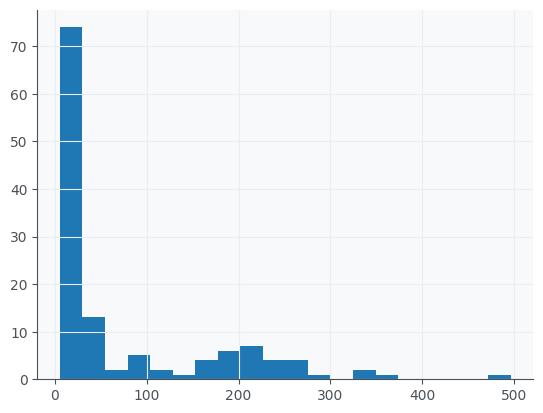

In [82]:
plt.hist(df_final['sdnn'].sort_values(), bins = 20)